In [3]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium

In [2]:
pip install folium


  Obtaining dependency information for folium from https://files.pythonhosted.org/packages/a2/1a/37c7ee1bc806d6c32621fecc72c19f6a9f9b4369e5e8f406a7c16d49f031/folium-0.15.0-py2.py3-none-any.whl.metadata
  Obtaining dependency information for branca>=0.6.0 from https://files.pythonhosted.org/packages/2f/e7/603b136221de923055716d23e3047da71f92e0d8ba2c4517ce49a54fe768/branca-0.7.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/100.3 kB ? eta -:--:--
   ---- ----------------------------------- 10.2/100.3 kB ? eta -:--:--
   ----------- --------------------------- 30.7/100.3 kB 435.7 kB/s eta 0:00:01
   -------------------------------------- 100.3/100.3 kB 958.1 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [124]:
base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.0/catalog/datasets/'

#Dataset name
dataset = 'soil-sensor-readings-historical-data'
number_of_records = 200

# Add a filter for the number of results returned
filters = f'records?limit={number_of_records}&offset=0&timezone=UTC'

soil_reading_url = f'{base_url}{dataset}/{filters}'
soil_reading_url

'https://data.melbourne.vic.gov.au/api/explore/v2.0/catalog/datasets/soil-sensor-readings-historical-data/records?limit=200&offset=0&timezone=UTC'

In [125]:
# Function that extracts the data from the JSON 
def get_data(base, data_url, offset = 0):
    
    filters = f'records?limit={100}&offset={offset}&timezone=UTC'
    url = f'{base}{data_url}/{filters}'
    result = requests.get(url)
    # if you need to extract more than 9900 records, enter the api key like below
    #result = requests.get(url + f'&apikey={API_KEY}')
    result_json = result.json()
    max_results = result_json['total_count']
    links = result_json['links']
    records = result_json['records']
    records_df = pd.json_normalize(records)
    
    # fix columns names
    records_df.drop(columns=['links'],inplace=True)
    column_names = records_df.columns.values.tolist()
    
    column_names = [i.split('.')[-1] for i in column_names]
    records_df.columns = column_names
    
    next_url = None
    
    # get next url
    if records_df.shape[0] != max_results:
        for l in links:
            if l['rel']=='next':
                next_url = l['href']
                
    return [records_df, next_url, column_names]

In [126]:
# Appends each set of data 
def add_to_dataframe(dataframe, new_data):
    df = pd.concat([dataframe, new_data])
    return df

In [127]:
# Extracts the data from the url to produce a pandas dataset
def extract_dataframe(dataset):
    df_new, url_next, column_names = get_data(base_url, dataset)
    df = pd.DataFrame(columns=column_names)
    while url_next != None:
        df_new, url_next, column_names = get_data(base_url, dataset, df.shape[0])
        df = add_to_dataframe(df, df_new)
        # This limits the dataset to only 9900 entries, should be removed if you want to import more data
        # To get more than 9900, enter the API key in the get data function
        if df.shape[0] == 9900:
            break
    return df

In [128]:
# Base url for v2 api
base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.0/catalog/datasets/'

# A filter at the end of the url
number_of_records = 100
filters = f'records?limit={number_of_records}&offset=0&timezone=UTC'

# The generated url
# dataset_url = f'{base_url}{dataset}/{filters}'

In [129]:
# Call the function and produce a dataframe
soil_df = extract_dataframe("soil-sensor-readings-historical-data")

In [109]:
# Use requests to get the data
result = requests.get(soil_reading_url)

In [110]:
result_json = result.json()
result_json.keys()

dict_keys(['total_count', 'links', 'records'])

In [111]:
result_json['total_count']

1504883

In [112]:
records = result_json['records']

In [113]:
soil_df = pd.json_normalize(records)
soil_df.drop(columns = ['links'], inplace=True)

In [114]:
column_names = soil_df.columns.values.tolist()
column_names = [i.split('.')[-1] for i in column_names]
soil_df.columns = column_names
soil_df = soil_df.drop(columns = 'id')

In [130]:
soil_df

,id,timestamp,size,local_time,site_name,site_id,id,probe_id,probe_measure,soil_value,unit,json_featuretype
0,200a9ce3d716056e20f45f6cf7d4ac72aec4cbf3,2023-09-01T07:08:46.91Z,128,2023-03-26T07:00:00+00:00,Treasury West,75509,16606654,1619058,Soil Moisture 80cm #0,48.91,%VWC,SoilSensorData
1,f33bd259c443e08967d418c19a5e849aa4df5eff,2023-09-01T07:08:46.91Z,134,2023-03-26T07:00:00+00:00,Treasury West,75509,16606662,1619067,Soil Temperature 80cm #0,17.96,ºC,SoilSensorData
2,57a6d3071c60c235c629c95d611ce81ea6ff112e,2023-09-01T07:08:46.91Z,134,2023-03-26T07:00:00+00:00,Princes Park Lawn 5,64993,16606675,1303869,Soil Moisture 40cm #0,33.79,%VWC,SoilSensorData
3,c517ba2d7110eeadf8c0b3311158b3e1f2ca0699,2023-09-01T07:08:46.91Z,140,2023-03-26T07:00:00+00:00,Princes Park Lawn 5,64993,16606694,1303877,Soil Salinity 30cm #0,0.21,µS/cm,SoilSensorData
4,fc9e9f6c4e8a522c36539070ad916fac8cc7db03,2023-09-01T07:08:46.91Z,140,2023-03-26T07:00:00+00:00,Princes Park Lawn 5,64993,16606713,1303875,Soil Salinity 10cm #0,0.07,µS/cm,SoilSensorData
...,...,...,...,...,...,...,...,...,...,...,...,...
95,2938b459e0e988335e39ececbcc3c1b290c4ab54,2023-09-01T07:08:46.91Z,136,2023-02-08T19:00:00+00:00,Bourke North 4,64983,16039392,1311659,Soil Moisture 60cm #0 (Sand),23.19,%VWC,SoilSensorData
96,c521e1427eb2f33b6e76fc0401b24f0d3279544b,2023-09-01T07:08:46.91Z,134,2023-02-09T05:00:00+00:00,Princes Park Lawn 5,64993,16039411,1303867,Soil Moisture 20cm #0,25.09,%VWC,SoilSensorData
97,fa5be62a0a45f9d5d1702d4b89cb8681c94b2e46,2023-09-01T07:08:46.91Z,134,2023-02-08T23:00:00+00:00,Bourke North 4,64983,16039414,1311651,Soil Temperature 70cm #0,21.20,ºC,SoilSensorData
98,17f7b947923efd5ab44a656624b846786fb23675,2023-09-01T07:08:46.91Z,134,2023-02-08T21:00:00+00:00,Bourke North 4,64983,16039418,1311651,Soil Temperature 70cm #0,21.20,ºC,SoilSensorData


In [116]:
# Use links & iterate calls

def get_data(base, data_url, offset = 0):
    
    filters = f'records?limit={100}&offset={offset}&timezone=UTC'
    url = f'{base}{data_url}/{filters}'
    result = requests.get(url)
    result_json = result.json()
    max_results = result_json['total_count']
    links = result_json['links']
    records = result_json['records']
    records_df = pd.json_normalize(records)
    
    # fix columns names
    records_df.drop(columns=['links'],inplace=True)
    column_names = records_df.columns.values.tolist()
    
    column_names = [i.split('.')[-1] for i in column_names]
    records_df.columns = column_names
    
    next_url = None
    
    # get next url
    if records_df.shape[0] != max_results:
        for l in links:
            if l['rel']=='next':
                next_url = l['href']
                
    return [records_df, next_url, column_names]

In [117]:
def add_to_dataframe(dataframe, new_data):
    df = pd.concat([dataframe, new_data])
    return df

In [118]:
def extract_dataframe(base_url, dataset):
    df_new, url_next, column_names = get_data(base_url, dataset)
    df = pd.DataFrame(columns=column_names)
    while url_next != None:
        df_new, url_next, column_names = get_data(base_url, dataset, df.shape[0])
        df = add_to_dataframe(df, df_new)
        if df.shape[0] == 9900:
            break
    return df

In [119]:
soil_df = extract_dataframe(base_url, dataset)

In [120]:

soil_df

,id,timestamp,size,local_time,site_name,site_id,id,probe_id,probe_measure,soil_value,unit,json_featuretype
0,200a9ce3d716056e20f45f6cf7d4ac72aec4cbf3,2023-09-01T07:08:46.91Z,128,2023-03-26T07:00:00+00:00,Treasury West,75509,16606654,1619058,Soil Moisture 80cm #0,48.91,%VWC,SoilSensorData
1,f33bd259c443e08967d418c19a5e849aa4df5eff,2023-09-01T07:08:46.91Z,134,2023-03-26T07:00:00+00:00,Treasury West,75509,16606662,1619067,Soil Temperature 80cm #0,17.96,ºC,SoilSensorData
2,57a6d3071c60c235c629c95d611ce81ea6ff112e,2023-09-01T07:08:46.91Z,134,2023-03-26T07:00:00+00:00,Princes Park Lawn 5,64993,16606675,1303869,Soil Moisture 40cm #0,33.79,%VWC,SoilSensorData
3,c517ba2d7110eeadf8c0b3311158b3e1f2ca0699,2023-09-01T07:08:46.91Z,140,2023-03-26T07:00:00+00:00,Princes Park Lawn 5,64993,16606694,1303877,Soil Salinity 30cm #0,0.21,µS/cm,SoilSensorData
4,fc9e9f6c4e8a522c36539070ad916fac8cc7db03,2023-09-01T07:08:46.91Z,140,2023-03-26T07:00:00+00:00,Princes Park Lawn 5,64993,16606713,1303875,Soil Salinity 10cm #0,0.07,µS/cm,SoilSensorData
...,...,...,...,...,...,...,...,...,...,...,...,...
95,2938b459e0e988335e39ececbcc3c1b290c4ab54,2023-09-01T07:08:46.91Z,136,2023-02-08T19:00:00+00:00,Bourke North 4,64983,16039392,1311659,Soil Moisture 60cm #0 (Sand),23.19,%VWC,SoilSensorData
96,c521e1427eb2f33b6e76fc0401b24f0d3279544b,2023-09-01T07:08:46.91Z,134,2023-02-09T05:00:00+00:00,Princes Park Lawn 5,64993,16039411,1303867,Soil Moisture 20cm #0,25.09,%VWC,SoilSensorData
97,fa5be62a0a45f9d5d1702d4b89cb8681c94b2e46,2023-09-01T07:08:46.91Z,134,2023-02-08T23:00:00+00:00,Bourke North 4,64983,16039414,1311651,Soil Temperature 70cm #0,21.20,ºC,SoilSensorData
98,17f7b947923efd5ab44a656624b846786fb23675,2023-09-01T07:08:46.91Z,134,2023-02-08T21:00:00+00:00,Bourke North 4,64983,16039418,1311651,Soil Temperature 70cm #0,21.20,ºC,SoilSensorData


In [131]:
soil_df['probe_measure'].unique()

array(['Soil Moisture 80cm #0', 'Soil Temperature 80cm #0',
       'Soil Moisture 40cm #0', 'Soil Salinity 30cm #0',
       'Soil Salinity 10cm #0', 'Soil Moisture 20cm #0 (Clayey Loam)',
       'Soil Moisture 30cm #0', 'Soil Temperature 10cm #0',
       'Soil Moisture 10cm #0', 'Soil Moisture 70cm #0 (Clay)',
       'Soil Moisture 80cm #0 (Clay)', 'Soil Temperature 70cm #0',
       'Soil Salinity 20cm #0', 'Soil Moisture 20cm #0',
       '#0 Soil Moisture 80cm', 'Soil Temperature 20cm #0',
       'Soil Moisture 60cm #0', '#0 Soil Moisture 70cm',
       'Soil Moisture 40cm #0 (Clay)', 'Soil Temperature 40cm #0',
       '#0 Soil Moisture 30cm', 'Soil Salinity 50cm #0',
       'Soil Moisture 50cm #0', '#0 Soil Moisture 60cm',
       '#0 Soil Moisture 40cm', 'Soil Salinity 40cm #0',
       'Soil Moisture 70cm #0', 'Soil Moisture 50cm #0 (Clay)',
       '#0 Soil Moisture 50cm', 'Soil Salinity 70cm #0',
       'Soil Temperature 50cm #0', 'Soil Moisture 30cm #0 (Clay)',
       'Soil Moisture

In [132]:
Temperature_10 = soil_df[soil_df['probe_measure'] == 'Soil Temperature 010cm']
Temperature_10 = Temperature_10.sort_values(by='local_time')
Temperature_10 


,id,timestamp,size,local_time,site_name,site_id,id,probe_id,probe_measure,soil_value,unit,json_featuretype
93,0f9fc711be205e790dc2dae0119fbffe991896c2,2023-09-01T07:08:46.91Z,142,2023-02-08T16:00:00+00:00,Southbank Bvd Playspace,126588,16038802,2239501,Soil Temperature 010cm,20.90,ºC,SoilSensorData
3,6c052fa818bf89a55cc6187d4f13481a3531d3b8,2023-09-01T07:08:46.91Z,143,2023-02-08T16:30:00+00:00,Southbank Bvd Playspace,126588,16038153,2239501,Soil Temperature 010cm,21.03,ºC,SoilSensorData
27,88e1cdbbe8b9f0f3a6a92da82abc8ed037262ce2,2023-09-01T07:08:46.91Z,143,2023-02-08T17:00:00+00:00,Southbank Bvd Playspace,126588,16038336,2239501,Soil Temperature 010cm,21.27,ºC,SoilSensorData
49,3577ed61206f8dabdc030c6ad01680de57778172,2023-09-01T07:08:46.91Z,143,2023-02-08T18:00:00+00:00,Southbank Bvd Playspace,126588,16038454,2239501,Soil Temperature 010cm,21.91,ºC,SoilSensorData
7,eed0d62d6d23b1dceb1aaf6d712ba1456c8495aa,2023-09-01T07:08:46.91Z,143,2023-02-08T18:30:00+00:00,Southbank Bvd Playspace,126588,16038176,2239501,Soil Temperature 010cm,22.31,ºC,SoilSensorData
68,7c701dd955a1fa8977e6ba2d917ddfc0c8575b4a,2023-09-01T07:08:46.91Z,143,2023-02-08T21:00:00+00:00,Southbank Bvd Playspace,126588,16038644,2239501,Soil Temperature 010cm,24.13,ºC,SoilSensorData
47,7ba0da125560bcb1062537b62209d5c8447f2e94,2023-09-01T07:08:46.91Z,143,2023-02-09T00:30:00+00:00,Southbank Bvd Playspace,126588,16038439,2239501,Soil Temperature 010cm,24.27,ºC,SoilSensorData
63,a2af824e2f7243757474aa814f52cca97c94f960,2023-09-01T07:08:46.91Z,143,2023-02-09T01:00:00+00:00,Southbank Bvd Playspace,126588,16038596,2239501,Soil Temperature 010cm,24.23,ºC,SoilSensorData
16,8697cc6bca8907150926e72c34a66990e88f771d,2023-09-01T07:08:46.91Z,143,2023-02-09T01:30:00+00:00,Southbank Bvd Playspace,126588,16038253,2239501,Soil Temperature 010cm,24.15,ºC,SoilSensorData
24,ddb96b6dc9fabe6b56543878a1e280813b7ce815,2023-09-01T07:08:46.91Z,143,2023-03-25T19:30:00+00:00,Southbank Bvd Playspace,126588,16605633,2239501,Soil Temperature 010cm,17.87,ºC,SoilSensorData


In [38]:
Temperature_20 = soil_df[soil_df['probe_measure'] == 'Soil Temperature 020cm']
Temperature_20 = Temperature_20.sort_values(by='local_time')
Temperature_20

,id,timestamp,size,local_time,site_name,site_id,id,probe_id,probe_measure,soil_value,unit,json_featuretype
37,d87563a6786991a9838a2f70ea4cbde320a3ed62,2023-09-01T07:08:46.91Z,143,2023-02-12T14:30:00+00:00,Southbank Bvd Playspace,126588,16090824,2239502,Soil Temperature 020cm,21.52,ºC,SoilSensorData
14,8b51e540ac500ce83de37e85b7e37163958c7d6a,2023-09-01T07:08:46.91Z,142,2023-02-12T15:00:00+00:00,Southbank Bvd Playspace,126588,16090640,2239502,Soil Temperature 020cm,21.50,ºC,SoilSensorData
67,db82de888c3b57cd4308b60301ac3f8e2fd0fd3d,2023-09-01T07:08:46.91Z,143,2023-02-12T17:00:00+00:00,Southbank Bvd Playspace,126588,16091148,2239502,Soil Temperature 020cm,21.44,ºC,SoilSensorData
62,987590297ce0ed2dfd0f05aa17a0d6036ff396ce,2023-09-01T07:08:46.91Z,143,2023-02-12T17:30:00+00:00,Southbank Bvd Playspace,126588,16091114,2239502,Soil Temperature 020cm,21.47,ºC,SoilSensorData
3,c0a7a7ee109dc03286370c552726f5677db27a6a,2023-09-01T07:08:46.91Z,143,2023-02-12T18:30:00+00:00,Southbank Bvd Playspace,126588,16090843,2239502,Soil Temperature 020cm,21.59,ºC,SoilSensorData
42,34a1383e5804104f5164a14f382bb7c67518c694,2023-09-01T07:08:46.91Z,143,2023-02-13T00:00:00+00:00,Southbank Bvd Playspace,126588,16091017,2239502,Soil Temperature 020cm,22.34,ºC,SoilSensorData
98,2cfc91fff1130686e76b820839de3a5fe7999a30,2023-09-01T07:08:46.91Z,143,2023-02-13T00:30:00+00:00,Southbank Bvd Playspace,126588,16091270,2239502,Soil Temperature 020cm,22.31,ºC,SoilSensorData
97,dab76ebe61729e2b04f1f81fc796f3b4e3ee3aa3,2023-09-01T07:08:46.91Z,143,2023-02-13T01:30:00+00:00,Southbank Bvd Playspace,126588,16091258,2239502,Soil Temperature 020cm,22.24,ºC,SoilSensorData
56,2e0a65a60b5c8fce5f87814b4e8b9876007542bd,2023-09-01T07:08:46.91Z,143,2023-02-13T02:00:00+00:00,Southbank Bvd Playspace,126588,16091088,2239502,Soil Temperature 020cm,22.18,ºC,SoilSensorData
18,f012586e6d5b9259b45b55d4b2cea38918137bdc,2023-09-01T07:08:46.91Z,143,2023-02-20T18:00:00+00:00,Southbank Bvd Playspace,126588,16196960,2239502,Soil Temperature 020cm,23.06,ºC,SoilSensorData


In [51]:
Temperature_30 = soil_df[soil_df['probe_measure'] == 'Soil Temperature 030cm']
Temperature_30 = Temperature_30.sort_values(by='local_time')
Temperature_30 

,id,timestamp,size,local_time,site_name,site_id,id,probe_id,probe_measure,soil_value,unit,json_featuretype
59,00b3fcbde21bce7044e5df08e65662097c167999,2023-09-01T07:08:46.91Z,143,2023-02-12T15:30:00+00:00,Southbank Bvd Playspace,126588,16091101,2239503,Soil Temperature 030cm,21.39,ºC,SoilSensorData
47,6f6a339b6c87c115f40e1e7497f7c2cf10eee877,2023-09-01T07:08:46.91Z,143,2023-02-12T16:00:00+00:00,Southbank Bvd Playspace,126588,16091027,2239503,Soil Temperature 030cm,21.38,ºC,SoilSensorData
9,b7ff92a0ceaba3896fb1694996b20cbe3bf966f6,2023-09-01T07:08:46.91Z,143,2023-02-12T19:00:00+00:00,Southbank Bvd Playspace,126588,16090924,2239503,Soil Temperature 030cm,21.46,ºC,SoilSensorData
88,66e7118a52b842e00bf255d939c3997db00ed4fa,2023-09-01T07:08:46.91Z,143,2023-02-12T20:00:00+00:00,Southbank Bvd Playspace,126588,16091158,2239503,Soil Temperature 030cm,21.62,ºC,SoilSensorData
24,94bfe2e0135ee3a62f06349e716fe4ee23c5a9f4,2023-09-01T07:08:46.91Z,143,2023-02-12T22:30:00+00:00,Southbank Bvd Playspace,126588,16090700,2239503,Soil Temperature 030cm,21.94,ºC,SoilSensorData
89,35a21d34202ebe65224c29acbc712d247ff90b95,2023-09-01T07:08:46.91Z,143,2023-02-13T01:30:00+00:00,Southbank Bvd Playspace,126588,16091162,2239503,Soil Temperature 030cm,21.93,ºC,SoilSensorData
89,5cebe359b82a419da36415eef2f3508aac00909f,2023-09-01T07:08:46.91Z,143,2023-02-20T15:30:00+00:00,Southbank Bvd Playspace,126588,16196763,2239503,Soil Temperature 030cm,23.15,ºC,SoilSensorData
22,55bbad07d4e19a3040a5979e2e43971c57320735,2023-09-01T07:08:46.91Z,143,2023-02-20T17:00:00+00:00,Southbank Bvd Playspace,126588,16196974,2239503,Soil Temperature 030cm,22.98,ºC,SoilSensorData
68,6d300b19b8d01accf2198572ad040b97b5d14c3d,2023-09-01T07:08:46.91Z,143,2023-02-20T20:00:00+00:00,Southbank Bvd Playspace,126588,16197330,2239503,Soil Temperature 030cm,23.18,ºC,SoilSensorData
52,6315c19fabb7870aff2404b2e6044204d915107c,2023-09-01T07:08:46.91Z,143,2023-02-23T15:00:00+00:00,Southbank Bvd Playspace,126588,16237170,2239503,Soil Temperature 030cm,23.63,ºC,SoilSensorData


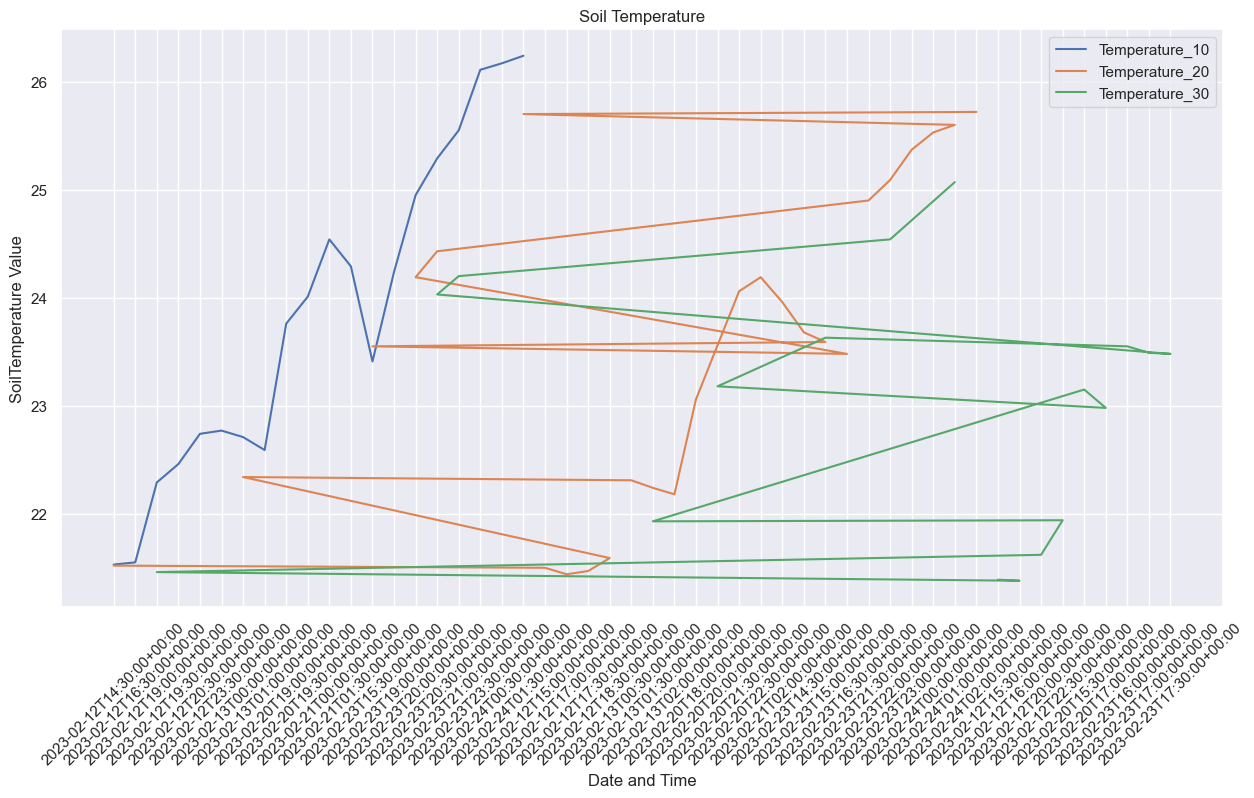

In [52]:
sns.set_theme()
fig, ax = plt.subplots(figsize=(15, 7.5))

ax.plot(Temperature_10['local_time'],Temperature_10['soil_value'], label = 'Temperature_10')
ax.plot(Temperature_20['local_time'], Temperature_20['soil_value'], label = 'Temperature_20')
ax.plot(Temperature_30['local_time'], Temperature_30['soil_value'], label = 'Temperature_30')



ax.set_xlabel("Date and Time")
ax.set_ylabel("SoilTemperature Value")
ax.set_title("Soil Temperature")

ax.tick_params(axis='x', rotation=45)


plt.legend()
plt.show()

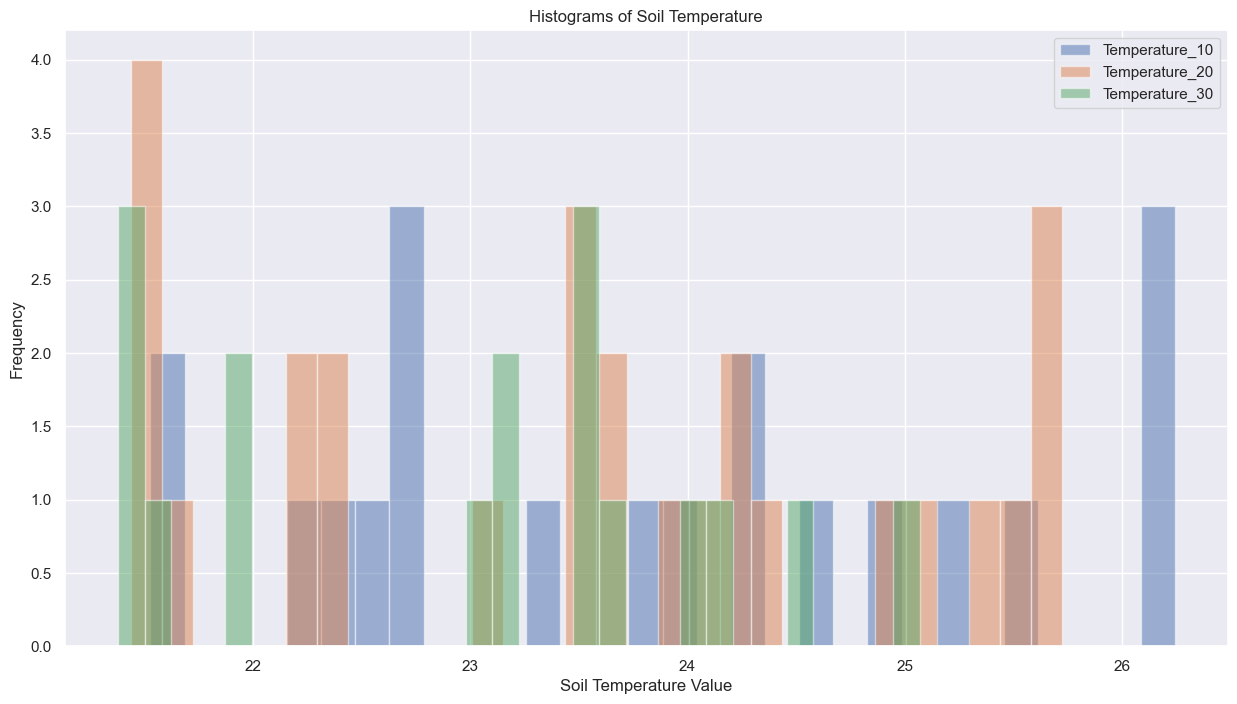

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

# Assuming temp_10, temp_20, and temp_30 are your DataFrame columns
plt.figure(figsize=(15, 8))

plt.hist(Temperature_10['soil_value'], bins = 30, alpha=0.5, label='Temperature_10')
plt.hist(Temperature_20['soil_value'],bins = 30, alpha=0.5, label='Temperature_20')
plt.hist(Temperature_30['soil_value'],bins = 30, alpha=0.5, label='Temperature_30')

plt.xlabel("Soil Temperature Value")
plt.ylabel("Frequency")
plt.title("Histograms of Soil Temperature")

plt.legend()
plt.show()



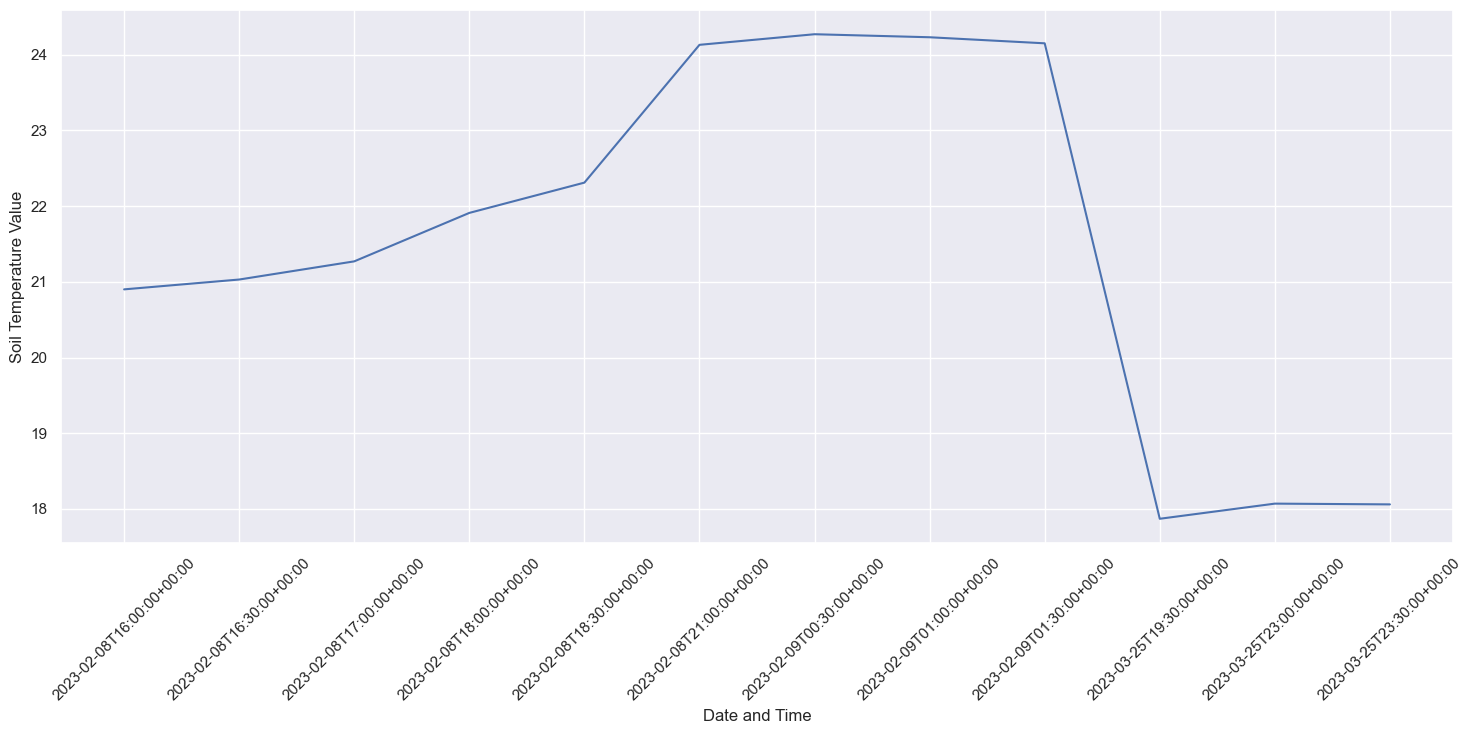

In [133]:
sns.set_theme()
fig, ax = plt.subplots(figsize=(15, 7.5))

ax.plot(Temperature_10['local_time'], Temperature_10['soil_value'])

ax.set_xlabel("Date and Time")
ax.set_ylabel("Soil Temperature Value")


ax.tick_params(axis='x', rotation=45)

plt.tight_layout()

plt.show()

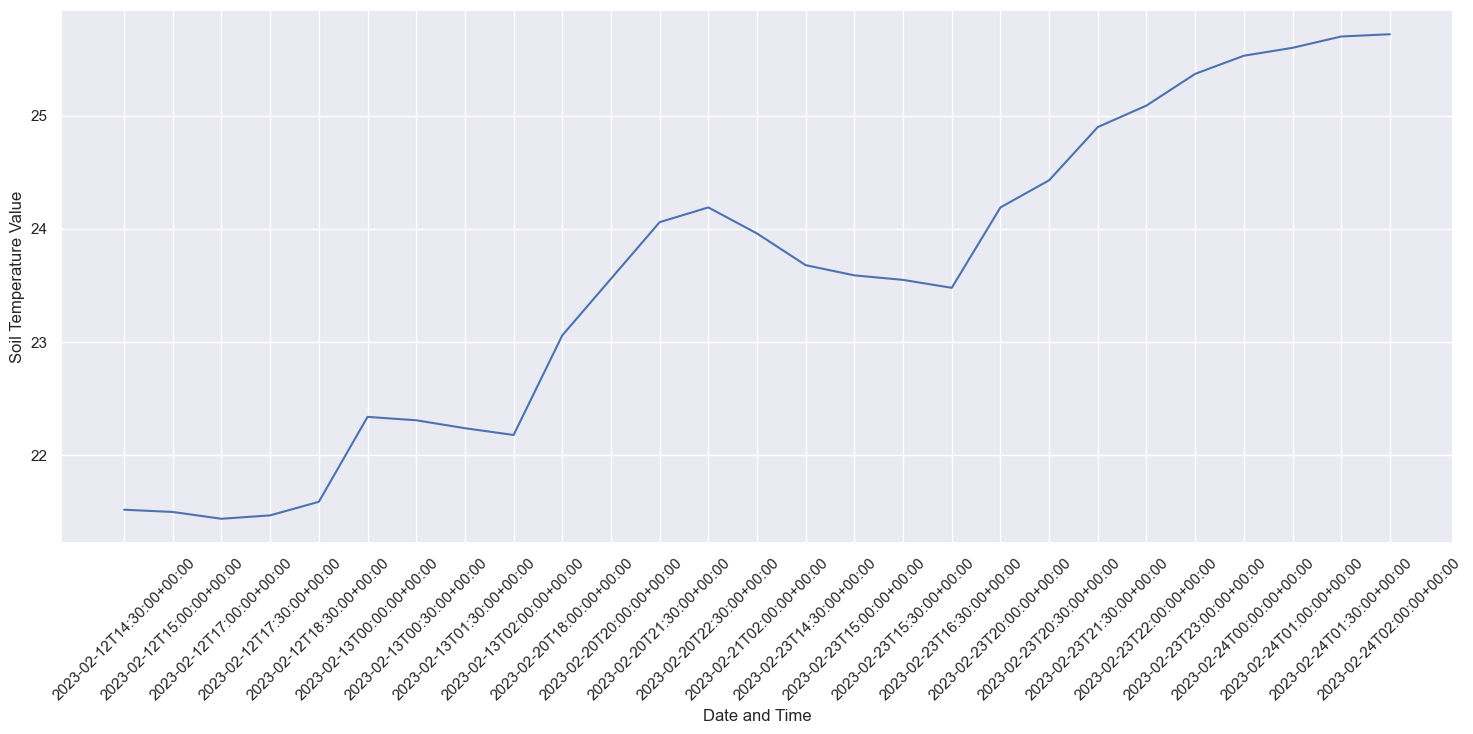

In [67]:
sns.set_theme()
fig, ax = plt.subplots(figsize=(15, 7.5))

ax.plot(Temperature_20['local_time'], Temperature_20['soil_value'])

ax.set_xlabel("Date and Time")
ax.set_ylabel("Soil Temperature Value")


ax.tick_params(axis='x', rotation=45)

plt.tight_layout()

plt.show()

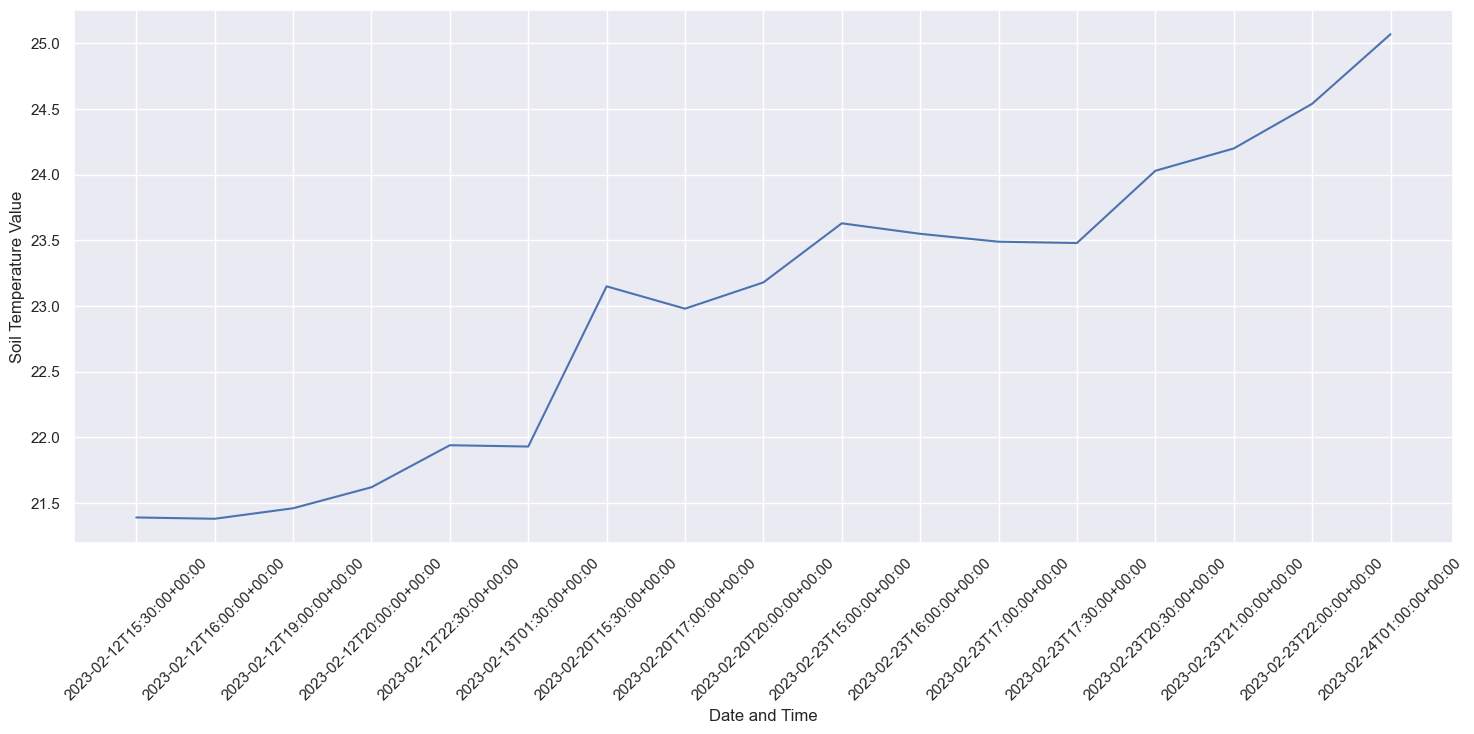

In [65]:
sns.set_theme()
fig, ax = plt.subplots(figsize=(15, 7.5))

ax.plot(Temperature_30['local_time'], Temperature_30['soil_value'])

ax.set_xlabel("Date and Time")
ax.set_ylabel("Soil Temperature Value")


ax.tick_params(axis='x', rotation=45)

plt.tight_layout()

plt.show()

In [70]:
base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'

#Dataset name
dataset = 'soil-sensor-locations'
number_of_records = 84

# Add a filter for the number of results returned
filters = f'records?limit={number_of_records}&offset=0&timezone=UTC'

soil_loc_url = f'{base_url}{dataset}/{filters}'
soil_loc_url

result = requests.get(soil_loc_url)
result_json = result.json()
records = result_json['results']
soil_loc = pd.json_normalize(records)

In [71]:
soil_loc

,site_id,site_name,property_name,latitude,longitude,location.lon,location.lat
0,50921,Replaced by op63369,Fitzroy Gardens,-37.81082691661315,144.98178719594011,144.981787,-37.810827
1,50924,Fitzroy West 09,Fitzroy Gardens,-37.81067469320403,144.979618148459,144.979618,-37.810675
2,64971,5th Fairway,Royal Park,-37.77920999998876,144.95251000000945,144.952510,-37.779210
3,64973,Argyle Square,Argyle Square,-37.8029015228744,144.966010728849,144.966011,-37.802902
4,64976,9th Fairway,Royal Park,-37.78291999998904,144.95566000000628,144.955660,-37.782920
...,...,...,...,...,...,...,...
79,70829,Royal Parade University college,None,-37.79202969998415,144.95872889999418,144.958729,-37.792030
80,72758,Royal Parade South,None,-37.79632980937252,144.9583068956953,144.958307,-37.796330
81,75500,Natures Play,Royal Park,-37.795338542639,144.95093324591195,144.950933,-37.795339
82,75502,Fawkner North,Fawkner Park,-37.838433712973945,144.981016125163,144.981016,-37.838434


In [121]:
soil_loc['latitude'] = soil_loc['latitude'].astype(float)
soil_loc['longitude'] = soil_loc['longitude'].astype(float)

In [136]:
# Create a base map
m = folium.Map(location=[soil_loc['latitude'].mean(), soil_loc['longitude'].mean()], zoom_start=15)

# Add markers for each sensor site
for _, row in soil_loc.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"Site ID: {row['site_id']}<br>Site Name: {row['site_name']}<br>Property Name: {row['property_name']}",
        icon=folium.Icon(icon="cloud"),
    ).add_to(m)

In [137]:
m

In [134]:
from folium.plugins import MarkerCluster

# Create a base map
m = folium.Map(location=[soil_loc['latitude'].mean(), soil_loc['longitude'].mean()], zoom_start=15)

# Create a Marker Cluster
marker_cluster = MarkerCluster().add_to(m)

# Add markers for each sensor site
for _, row in soil_loc.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"Site ID: {row['site_id']}<br>Site Name: {row['site_name']}<br>Property Name: {row['property_name']}",
        icon=folium.Icon(icon="cloud"),
    ).add_to(marker_cluster)


In [139]:
pip install geopandas


  Obtaining dependency information for geopandas from https://files.pythonhosted.org/packages/3e/cf/ede993ed7070c5487e6db550aad490178c06eaa48ad26ff5e5263f995fba/geopandas-0.14.1-py3-none-any.whl.metadata
  Obtaining dependency information for fiona>=1.8.21 from https://files.pythonhosted.org/packages/7f/27/b24c1610c7ae5716709321f04d38d7b8b71ed531f80df4f697b9ad99cfc3/fiona-1.9.5-cp311-cp311-win_amd64.whl.metadata
     ---------------------------------------- 0.0/51.1 kB ? eta -:--:--
     --------------- ---------------------- 20.5/51.1 kB 640.0 kB/s eta 0:00:01
     -------------------------------------- 51.1/51.1 kB 517.4 kB/s eta 0:00:00
  Obtaining dependency information for pyproj>=3.3.0 from https://files.pythonhosted.org/packages/79/95/eb68113c5b5737c342bde1bab92705dabe69c16299c5a122616e50f1fbd6/pyproj-3.6.1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for shapely>=1.8.0 from https://files.pythonhosted.org/packages/9e/39/029c441d8af32ab423b229c4525ce5ce67

In [142]:
Salinity_10 = soil_df[soil_df['probe_measure'] == 'Soil Salinity 10cm']
Salinity_10 = Salinity_10.sort_values(by='local_time')
Salinity_10 


,id,timestamp,size,local_time,site_name,site_id,id,probe_id,probe_measure,soil_value,unit,json_featuretype
83,fdd2985b73d09ba42c5a03fd0c8190097297c6d1,2023-09-01T07:08:46.91Z,132,2023-01-18T05:30:00+00:00,Bourke South 3,88425,15759184,1914096,Soil Salinity 10cm,0.17,µS/cm,SoilSensorData
94,9480f15b7d50fcead96adb6560b8ae8a9bc91d7c,2023-09-01T07:08:46.91Z,141,2023-01-18T05:30:00+00:00,Princess bridge NE p11,101037,15756564,2019348,Soil Salinity 10cm,0.01,µS/cm,SoilSensorData
78,769a2a1a61401012b06b936ba1977b24a882d4b8,2023-09-01T07:08:46.91Z,132,2023-01-18T06:00:00+00:00,Bourke South 3,88425,15755208,1914096,Soil Salinity 10cm,0.17,µS/cm,SoilSensorData
76,3da042098f027eab653d240dec077adc49790ed7,2023-09-01T07:08:46.91Z,141,2023-01-18T06:00:00+00:00,Princess bridge SW p10,101034,15757095,2019287,Soil Salinity 10cm,0.04,µS/cm,SoilSensorData
80,2bb1c96070b529ec1af847d84cadcd75958e6401,2023-09-01T07:08:46.91Z,140,2023-01-18T06:30:00+00:00,Princess bridge NW p01,101032,15759166,2019267,Soil Salinity 10cm,0.00,µS/cm,SoilSensorData
...,...,...,...,...,...,...,...,...,...,...,...,...
91,e2a51e0864634e751c322225f802cefb05bef8eb,2023-09-01T07:08:46.91Z,142,2023-03-26T17:00:00+00:00,Princess bridge East p06,101038,16610088,2019368,Soil Salinity 10cm,0.00,µS/cm,SoilSensorData
78,096c93cf91c9e46c9ab767514d8036c966a67c62,2023-09-01T07:08:46.91Z,140,2023-03-26T17:00:00+00:00,Princess bridge NE p11,101037,16610498,2019348,Soil Salinity 10cm,0.00,µS/cm,SoilSensorData
21,f5c89a92a21cc83991ff43f463f8ed061f0ffad4,2023-09-01T07:08:46.91Z,140,2023-03-26T17:00:00+00:00,Princess bridge NW p01,101032,16612776,2019267,Soil Salinity 10cm,0.00,µS/cm,SoilSensorData
92,4c4d89cb1a686ef7227892b82c2653f2d32e8efd,2023-09-01T07:08:46.91Z,141,2023-03-26T17:00:00+00:00,Princess bridge SW p10,101034,16612379,2019287,Soil Salinity 10cm,0.03,µS/cm,SoilSensorData


In [148]:
sns.set_theme()
fig, ax = plt.violinplots(figsize=(15, 7.5))

ax.plot(Salinity_10 ['local_time'], Salinity_10 ['soil_value'])

ax.set_xlabel("Date and Time")
ax.set_ylabel("Soil Temperature Value")


ax.tick_params(axis='x', rotation=45)

plt.tight_layout()

plt.show()

AttributeError: module 'matplotlib.pyplot' has no attribute 'violinplots'

In [146]:
soil_df['site_name'].unique()

array(['Treasury West', 'Princes Park Lawn 5', '9th Fairway',
       'Princess bridge East p06', 'Toms Block', 'Bourke South 4',
       'Flagstaff Gardens 2', 'Natures Play', 'Bourke South 3',
       'Bourke South 5', 'Treasury Gardens North', 'Bourke North 5',
       'Flagstaff Gardens 3', 'Royal Parade CSIRO', 'Kings Domain North',
       'Carlton Gardens South 1', 'Argyle Square', 'Princes Park Oval 3',
       'Alexandra Gardens Engineers Lawn', 'Docklands Park South',
       'Princess bridge SW p10', 'Shrine Reserve South East',
       'Bourke South 1', 'Princes Park Oval 2',
       "Fitzroy Gardens West '18", 'Princess bridge NW p01',
       'Ransford Oval', 'Speakers Corner', 'Fawkner North',
       'Princess bridge NE p11', "Fitzroy Gardens East '18",
       'Western Oval', 'Bourke North 2', 'Carlton Gardens North',
       'Point Park', 'Conservatory', 'McAlister Oval', '8th Green',
       'Southbank Bvd Playspace', 'Bourke South 2', 'Bourke North 4',
       'Cnr Barry & Leicest